## Process spatial averages from 1D NWM files without using DASK

This process would be well suited for dask, but I cannot get this process to work for the full 10 year dataset using Dask. This notebook is an attempt to process the data one timestep at a time and aggregated a new dataset along a time dimension as the process continues. It currently fits in memory (<3Gb utilized) for the process and takes about 25 minutes to complete for 135 timesteps.

### Import Modules

In [1]:
# --- Import Modules --- #

# Import Python Core Modules
import sys
import os
import time
import datetime
from pathlib import Path

# Import Additional Modules
import numpy as np
import xarray as xr
import pandas as pd
import zarr
import flox.xarray

# Import functions from local repository
sys.path.append(r'/glade/derecho/scratch/ksampson/Water_Budget/usgs_water/daily_retro')
from usgs_common import *

tic = time.time()
print('Process initiated at {0}'.format(time.ctime()))
# --- End Import Modules --- #

Process initiated at Thu Apr 25 16:17:41 2024


### Setup global variables, input and outputs and other options

In [2]:
# --- Globals --- #

# Choose a region subset
region = 'CONUS'

# Input directory containing model outputs
#inDir = r'/glade/p/ral/hap/adugger/projects/USGS_HyTEST/WaterBudget/datasets/IWAA_WH/monthly_files/wrfhydro_10yr'
inDir = r'/glade/campaign/ncar/USGS_Water/adugger/IWAA/retro_42yr/monthly_files'

# Input mapping file for model catchments to analysis catchments
Use_Mapping_File = True
Mapping_File = r'/glade/derecho/scratch/ksampson/USGS/CONUS_Water_Budget/HUCs/Final_HUC12IDs.csv'

# Give a name to the zone dataset, which will be the name of the zone variable
zone_name = 'WBDHU12'

# Specify the field in the input file that contains local model catchment areas
area_field = 'NWM_Catchment_Area' 

# Specify the field in the input file that contains the mapping between model catchments and aggregation units
mapping_field = 'HUC12_FL' # Use this since it maps all flowlines to HUC12, an matches the catchment mapping

# Specify the field in the input file that contains the IDs of the model catchments
mapping_ID = 'ID'

# Peform spatial aggregation?
spatial_aggregation = True

# Resample the time variable?
resample_time = False
resample_time_period = "1D"

# Perform temporal subset on inputs?
temporal_subset = False
#time_subset_bounds = slice('2009-10-01', '2019-09-30')     # First IWAAS batch
#time_subset_bounds = slice('2019-10-01', '2021-09-30')     # Second IWAAS batch
time_subset_bounds = slice('2009-10-01', '2021-09-30')     # Second IWAAS batch

# Fill NaN values in the Area_sqkm (used as weights on the variable) field with a particular value?
fill_na_value = 0     

# Specify units name - only used in output file names and netCDF variable attribute "units"
units = 'mm'

# Output directory
outDir = r'/glade/derecho/scratch/ksampson/USGS/CONUS_Water_Budget/Water_Budget'

# Output filename pattern
output_pattern = 'CONUS_HUC12_WB_1D_19791001_20220930'

# Select output formats
write_NC = True      # Output netCDF file
write_CSV = True     # Output CSV file

# 1D variables, input files, and other options
Variables = ['totOutflow', 'totInflow', 'deltaDepth', 'avgDepth', 'totqBucket', 'totqSfcLatRunoff', 'totStreamflow'] # Manually specify variables
convert_to_mm = True                    # Output is in mm^3s^-1. Divide by m^2 and multiply by 1000 to get mm
convert_to_mm_list = ['totOutflow', 'totInflow', 'totqBucket', 'totqSfcLatRunoff', 'totStreamflow']

# --- End Globals --- #

### Functions

In [3]:
# --- Functions --- #

def extract_dates(in_paths=[]):
    dt_strings = [os.path.basename(in_path).split('.nc')[0].split('_')[1] for in_path in in_paths]
    dt_obj = pd.to_datetime(dt_strings, format='%Y%m')
    return dt_obj

# --- End Functions --- #

### Read input mapping file from CSV

In [4]:
# Examine files in input directory
file_in = get_files_wildcard(inDir, file_pattern='gw_*.nc', recursive=False)
file_in2 = get_files_wildcard(inDir, file_pattern='chrt_*.nc', recursive=False)
assert len(file_in) == len(file_in2)

# Create a dataframe from the input HUC12 mapping file
df = pd.read_csv(Mapping_File, index_col=[0])
df2 = pd.read_csv(Mapping_File, index_col=[0], dtype={'HUC12_FL':str, 'HUC12_CA':str})

# Create a new field that is a string type based on the HUC12 IDs. This is for outputs
df['HUC12_FL_str'] = df2['HUC12_FL']
df['HUC12_CA_str'] = df2['HUC12_CA']
del df2

Found 516 files using wildcard "gw_*.nc" (recursive=False) in the input directory:
	 /glade/campaign/ncar/USGS_Water/adugger/IWAA/retro_42yr/monthly_files
Found 516 files using wildcard "chrt_*.nc" (recursive=False) in the input directory:
	 /glade/campaign/ncar/USGS_Water/adugger/IWAA/retro_42yr/monthly_files


### Define variables to drop from inputs

In [6]:
# Open the selected dataset(s), dropping variables as necessary
drop_vars = [variable for variable in xr.open_dataset(file_in[0]) if variable not in Variables+[time_coord]]
drop_vars += [variable for variable in xr.open_dataset(file_in2[0]) if variable not in Variables+[time_coord]]
drop_vars += ['crs']
drop_vars = list(set(drop_vars))
print('Dropping {0} from input file.'.format(drop_vars))

Dropping ['crs'] from input file.


In [7]:
# Hack to limit the number of files to process (for IWAAs batch 2)
# file_in = file_in[-24:]
# file_in2 = file_in2[-24:]

### Iterate over every set of files, one timestep at a time

This will keep memory usage low, but all data will be stored in memory.

In [7]:
%%time
# -------- Main codeblock -------- #

# Iterate over each pair of input timesteps
for n, (infile1, infile2) in enumerate(zip(file_in, file_in2)):
    tic2 = time.time()

    # This is a little complicated because we will be building multiple datasets
    ds_list = [xr.open_dataset(infile,
                               decode_cf=False,
                               drop_variables=drop_vars) for infile in [infile1, infile2]]
    datetimes = [extract_dates(in_list) for in_list in [[infile1], [infile2]]]
    ds_list = [ds.assign_coords(time=datetimes_in) for ds, datetimes_in in zip(ds_list, datetimes)]
    ds_input = xr.merge(ds_list)
    print('[{0}]\t{1}'.format(n, datetimes[0]))
    del ds_list, datetimes

    # Subset to only the varialbes in the input DataSet
    Variables = [variable for variable in Variables if variable in ds_input.data_vars]

    # Align (sort) the data to match ID ordering in the xarray dataset
    if n == 0:
        # Create dataframe from input Xarray dataset feature IDs from NWM output file
        feature_IDs = pd.DataFrame(ds_input['feature_id'].to_pandas())
        feature_IDs = feature_IDs.rename(columns={feature_IDs.columns[0]:feature_id})
        assert (feature_IDs[feature_id] == ds_input['feature_id']).sum() == ds_input['feature_id'].shape[0]

        # Perform attribute join to obtain HUC12 for each feature
        feature_IDs = feature_IDs.merge(df, how='left', left_on=feature_id, right_on='ID')
        assert (feature_IDs[feature_id] == ds_input['feature_id']).sum() == ds_input['feature_id'].shape[0]

    # Add HUC data to Xarray dataset to facilitate GroupBy operations later
    ds_input[zone_name] = xr.DataArray(feature_IDs[mapping_field], dims='feature_id', coords={'feature_id':ds_input['feature_id']})
    ds_input['HUC_12_str'] = xr.DataArray(feature_IDs['HUC12_FL_str'], dims='feature_id', coords={'feature_id':ds_input['feature_id']})
    ds_input['Area_sqkm'] = xr.DataArray(feature_IDs[area_field], dims='feature_id', coords={'feature_id':ds_input['feature_id']})

    # Iterate over variables, processing each one
    for n2,Variable in enumerate(Variables):

        # Try doing Flox groupby before applying time aggregation
        if spatial_aggregation:

            # Get the area totals by HUC
            area_totals = ds_input['Area_sqkm'].groupby(ds_input[zone_name]).sum()

            # Multiply by basin area to weight the observations
            if Variable in ['depth', 'avgDepth', 'deltaDepth']:
                area_weight = True
                if area_weight:
                    stat = 'sum'
                    weight = ds_input['Area_sqkm']
                else:
                    stat = 'mean'
                    weight = 1.
            else:
                area_weight = False
                weight = 1.
                stat = 'sum'

            # Perform the reduction to get HUC mean for each timestep
            tic1 = time.time()
            output = flox.xarray.xarray_reduce(
                ds_input[Variable] * weight,
                ds_input[zone_name],
                func=stat).compute()

            # Divide by the HUC total area to convert back to original units (mm)
            assert (output[zone_name] == area_totals[zone_name]).sum() == output[zone_name].shape[0]
            if area_weight and stat=='sum':
                output = output/area_totals
        else:
            output = ds_input

            # Get the area totals by original features
            area_totals = ds_input['Area_sqkm']
            assert (output['feature_id'] == area_totals['feature_id']).sum() == output['feature_id'].shape[0]

        # Resample and rechunk using mean over days
        if resample_time:
            print('  Resampling time using mean over time="{0}".'.format(resample_time_period))
            stat = 'mean'

            # Find the size of the output array after resampling
            resampled_time_length = output.isel({zone_name:slice(0,1,None)}).resample(time=resample_time_period).mean(dim=time_coord).shape[0]

            # Peform temporal aggregation
            da_output = (
                output
                .resample(time=resample_time_period)
                .mean(dim=time_coord)
                .chunk({time_coord: resampled_time_length}))

            # Convert to Xarray DataSet
            da_output = da_output.to_dataset(name=Variable)

        else:
            stat = ''
            da_output = output
            da_output = da_output.to_dataset(name=Variable)

        # Put time back in (lost if there is only 1 time in the inputs)
        da_output = da_output.assign_coords({time_coord:ds_input[time_coord]})

        # Rename the variable
        da_output[Variable].attrs['long_name'] = "{0}".format(Variable)
        da_output[Variable].attrs['units'] = "{0}".format(units)
        da_output['Area_sqkm'] = area_totals

        # convert from rate (m^3/s) to depth (m) over a day (86400s)
        if convert_to_mm and Variable in convert_to_mm_list:
            mm_per_m = 1000
            da_output[Variable] = da_output[Variable]/(da_output['Area_sqkm']*1000000) * mm_per_m

        if n2 == 0:
            out_ds = da_output
        else:
            out_ds[Variable] = da_output[Variable]
    
    if n == 0:
        out_ds2 = out_ds
    else:
        out_ds2 = xr.concat([out_ds2, out_ds], dim=time_coord)        
    print('Time elapsed per file pair: {0:3.2f} seconds.'.format(time.time()-tic2))

# Fix the 1D variable
out_ds2['Area_sqkm'] = out_ds2['Area_sqkm'].isel({time_coord:0}).squeeze()

# Remove fields not needed
#out_ds2 = out_ds2.drop(labels=['Area_sqkm'])

# Transpose the dimension order so that output is (HUC,time)
out_ds2 = out_ds2.transpose()

[0]	DatetimeIndex(['1979-10-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 11.72 seconds.
[1]	DatetimeIndex(['1979-11-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.72 seconds.
[2]	DatetimeIndex(['1979-12-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.05 seconds.
[3]	DatetimeIndex(['1980-01-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.07 seconds.
[4]	DatetimeIndex(['1980-02-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.03 seconds.
[5]	DatetimeIndex(['1980-03-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.62 seconds.
[6]	DatetimeIndex(['1980-04-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.00 seconds.
[7]	DatetimeIndex(['1980-05-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.28 seconds.
[8]	DatetimeIndex(['1980-06-01'], dtype='datetime64[ns]', freq=None)
Time elapsed per file pair: 10.17 s

In [8]:
out_ds2

<xarray.Dataset>
Dimensions:           (WBDHU12: 83274, time: 516)
Coordinates:
  * WBDHU12           (WBDHU12) float64 1.01e+10 1.01e+10 ... 1.81e+11 1.81e+11
  * time              (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2022-09-01
Data variables:
    totOutflow        (WBDHU12, time) float64 49.09 59.5 ... 0.04235 0.03998
    Area_sqkm         (WBDHU12) float64 74.25 81.73 75.25 ... 103.5 160.8 941.5
    totInflow         (WBDHU12, time) float64 49.62 58.7 ... 0.02323 0.02444
    deltaDepth        (WBDHU12, time) float64 0.5807 -0.8804 ... -0.01593
    avgDepth          (WBDHU12, time) float64 28.18 31.2 25.23 ... 0.7513 0.733
    totqBucket        (WBDHU12, time) float64 49.09 59.5 ... 0.04235 0.03998
    totqSfcLatRunoff  (WBDHU12, time) float64 5.523 6.367 2.486 ... 0.0 0.003516
    totStreamflow     (WBDHU12, time) float64 369.0 405.8 278.5 ... 55.46 92.12

In [9]:
# Perform temporal subset, or not
if temporal_subset:
    out_ds2 = out_ds2.loc[{time_coord:time_subset_bounds}]
out_ds2 

<xarray.Dataset>
Dimensions:           (WBDHU12: 83274, time: 516)
Coordinates:
  * WBDHU12           (WBDHU12) float64 1.01e+10 1.01e+10 ... 1.81e+11 1.81e+11
  * time              (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2022-09-01
Data variables:
    totOutflow        (WBDHU12, time) float64 49.09 59.5 ... 0.04235 0.03998
    Area_sqkm         (WBDHU12) float64 74.25 81.73 75.25 ... 103.5 160.8 941.5
    totInflow         (WBDHU12, time) float64 49.62 58.7 ... 0.02323 0.02444
    deltaDepth        (WBDHU12, time) float64 0.5807 -0.8804 ... -0.01593
    avgDepth          (WBDHU12, time) float64 28.18 31.2 25.23 ... 0.7513 0.733
    totqBucket        (WBDHU12, time) float64 49.09 59.5 ... 0.04235 0.03998
    totqSfcLatRunoff  (WBDHU12, time) float64 5.523 6.367 2.486 ... 0.0 0.003516
    totStreamflow     (WBDHU12, time) float64 369.0 405.8 278.5 ... 55.46 92.12

In [10]:
%%time

# Write output file (CSV)
if write_CSV:
    tic1 = time.time()
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20091001_20190930.csv'.format(region))
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20191001_20210930.csv'.format(region))
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20091001_20210930.csv'.format(region))
    out_file = os.path.join(outDir, output_pattern+'.csv')
    
    # Interpret times as strings
    datetime_strings = pd.to_datetime(out_ds2[time_coord]).strftime('%Y%m%d')

    if os.path.exists(out_file):
        tic1 = time.time()
        df_in = pd.read_csv(out_file)
        df_out = pd.concat([df_in, out_ds2.to_dataframe()])
        df_out.to_csv(out_file)
        print('\t      Output file written in {0:3.2f} seconds.'.format(time.time()-tic1))

    else:
        #write_csv(out_ds, out_file, columns=output['HUC_12'], index=[datetime_strings])
        write_csv(out_ds2, out_file, columns=out_ds2[zone_name], index=[datetime_strings])
    print('\tExport to CSV completed in {0:3.2f} seconds.'.format(time.time()-tic1))

# Write output file (netCDF)
if write_NC:
    tic1 = time.time()
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20091001_20190930.nc'.format(region))
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20191001_20210930.nc'.format(region))
    #out_file = os.path.join(outDir, '{0}_HUC12_WB_1D_20091001_20210930.nc'.format(region))
    out_file = os.path.join(outDir, output_pattern+'.nc')
    
    if os.path.exists(out_file):
        in_ds = xr.open_dataset(out_file).load()
        out_ds3 = xr.merge([in_ds, out_ds2])
        #out_ds3 = xr.concat([in_ds, out_ds], dim=time_coord)
        in_ds.close()
        del in_ds
        print('  Writing output to {0}'.format(out_file))
        out_ds3.to_netcdf(out_file, mode='w', format="NETCDF4", compute=True)
        out_ds3.close()
    else:
        print('  Writing output to {0}'.format(out_file))
        out_ds2.transpose().to_netcdf(out_file, mode='w', format="NETCDF4", compute=True)
    print('\tExport to netCDF completed in {0:3.2f} seconds.'.format(time.time()-tic1))

	      Output file written in 763.15 seconds.
	Export to CSV completed in 763.57 seconds.
  Writing output to /glade/scratch/ksampson/USGS/CONUS_Water_Budget/Water_Budget/CONUS_HUC12_WB_1D_19791001_20220930.nc
	Export to netCDF completed in 19.20 seconds.
CPU times: user 11min 32s, sys: 14.4 s, total: 11min 46s
Wall time: 13min 2s


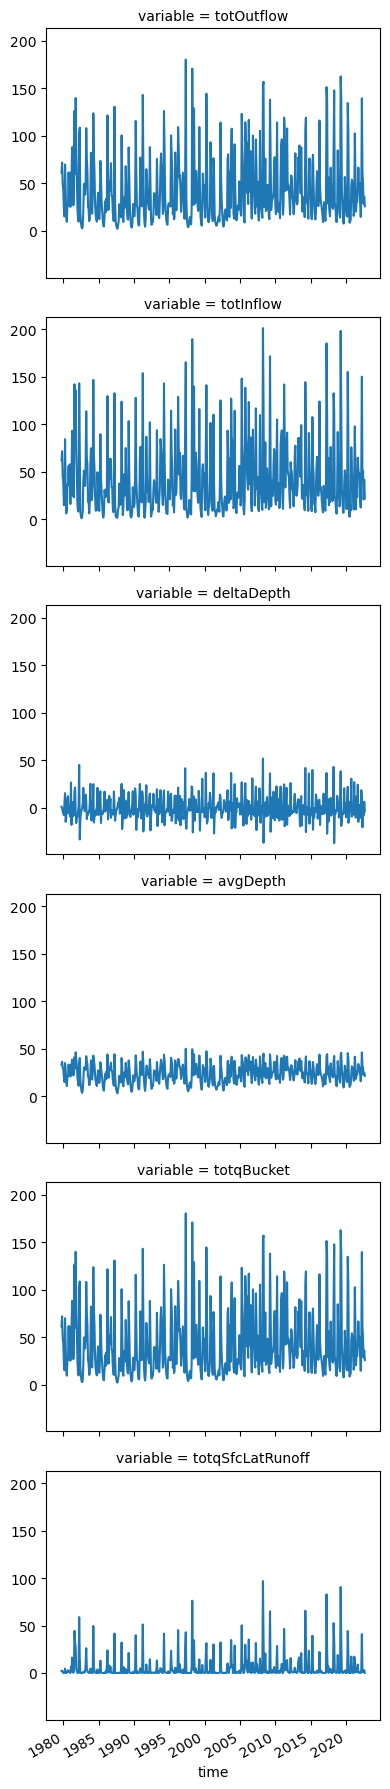

In [11]:
# Plot all variables to see ranges of values
vars_to_plot = [variable for variable in out_ds2.data_vars if variable not in ['totStreamflow', 'Area_sqkm']] 
out_ds2[vars_to_plot].isel({zone_name:2}).to_array().plot(row='variable')

In [12]:
out_ds2.close()

In [13]:
print('Process completed in {0: 3.2f} seconds.'.format(time.time()-tic))

Process completed in  8256.05 seconds.
